In [2]:
!pip install sklearn-crfsuite

In [3]:
import nltk
import pandas as pd
#import sklearn_crfsuite
#from sklearn_crfsuite import metrics

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

root = '/content/gdrive/MyDrive/Colab Notebooks/torch/'
df = pd.read_csv(root+'data/NER-dataset/ner_dataset.csv', encoding = "ISO-8859-1")
# Annotated Corpus for Named Entity Recognition using GMB
# (Groningen Meaning Bank) corpus for named entity classification.
# https://www.kaggle.com/code/abhinavwalia95/how-to-loading-and-fitting-dataset-to-scikit/input
# https://github.com/iresiragusa/NLP/blob/main/datasets/ner_dataset.csv

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
df[:13]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [6]:
# TASK
#   POS tagging w/ CRF
#   NER tagging w/ CRF (Tag field in the dataset)

# note that in this notebook only NER tagging is done as in Esercitazione3a

In [7]:
# custom train/test split due to RAM limitations

for i in range(len(df)):
  if df.at[i, 'Sentence #'] == 'Sentence: 2001':
    idx_train = i
  if df.at[i, 'Sentence #'] == 'Sentence: 2051':
    idx_test = i
    break

In [8]:
df_train = df.iloc[:idx_train].reset_index()
df_test = df.iloc[idx_train:idx_test].reset_index()

In [9]:
# ner tags in the dataset + Other tag
# ner are annotated via BIO encoding

#geo = Geographical Entity
#org = Organization
#per = Person
#gpe = Geopolitical Entity
#tim = Time indicator
#art = Artifact
#eve = Event
#nat = Natural Phenomenon

In [10]:
df_train

,index,Sentence #,Word,POS,Tag
0,0,Sentence: 1,Thousands,NNS,O
1,1,NaN,of,IN,O
2,2,NaN,demonstrators,NNS,O
3,3,NaN,have,VBP,O
4,4,NaN,marched,VBN,O
...,...,...,...,...,...
44391,44391,NaN,Ruiz,NNP,I-per
44392,44392,NaN,over,IN,O
44393,44393,NaN,corruption,NN,O
44394,44394,NaN,allegations,NNS,O


In [11]:
# fill the NaN gaps in the dataframe

df_train = df_train.fillna(method='ffill')
print(df_train['Sentence #'].nunique(), df_train.Word.nunique(), df_train.Tag.nunique())

df_test = df_test.fillna(method='ffill')
print(df_test['Sentence #'].nunique(), df_test.Word.nunique(), df_test.Tag.nunique())

2000 7050 17
50 513 10


/tmp/ipython-input-1610059076.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train = df_train.fillna(method='ffill')
/tmp/ipython-input-1610059076.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test = df_test.fillna(method='ffill')


In [12]:
df_train

,index,Sentence #,Word,POS,Tag
0,0,Sentence: 1,Thousands,NNS,O
1,1,Sentence: 1,of,IN,O
2,2,Sentence: 1,demonstrators,NNS,O
3,3,Sentence: 1,have,VBP,O
4,4,Sentence: 1,marched,VBN,O
...,...,...,...,...,...
44391,44391,Sentence: 2000,Ruiz,NNP,I-per
44392,44392,Sentence: 2000,over,IN,O
44393,44393,Sentence: 2000,corruption,NN,O
44394,44394,Sentence: 2000,allegations,NNS,O


      Tag  counts
0   B-art      46
1   B-eve      32
2   B-geo    1286
3   B-gpe     884
4   B-nat      18
5   B-org     874
6   B-per     697
7   B-tim     770
8   I-art      25
9   I-eve      24
10  I-geo     249
11  I-gpe      30
12  I-nat       9
13  I-org     616
14  I-per     814
15  I-tim     209
16      O   37813


<Axes: xlabel='Tag'>

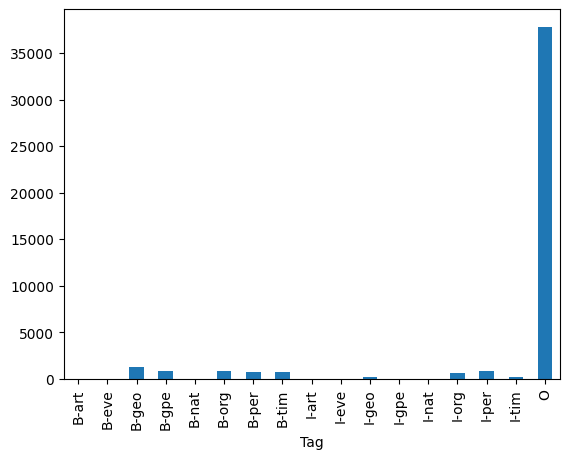

In [13]:
# getting statistics of the dataframe
print(df_train.groupby('Tag').size().reset_index(name='counts'))
df_train.groupby(['Tag']).size().plot.bar()

     Tag  counts
0  B-geo      41
1  B-gpe      16
2  B-org      21
3  B-per      16
4  B-tim      17
5  I-geo      13
6  I-org      22
7  I-per      24
8  I-tim       2
9      O     881


<Axes: xlabel='Tag'>

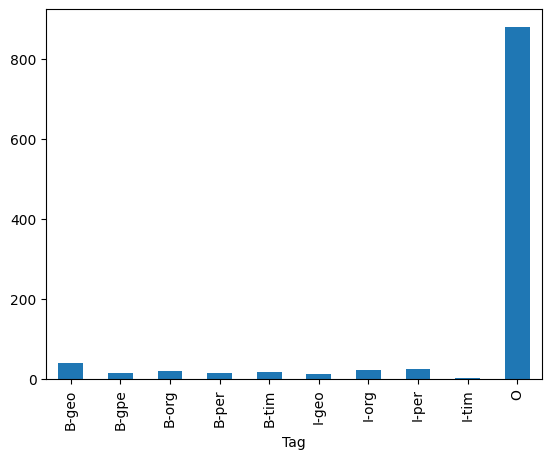

In [14]:
print(df_test.groupby('Tag').size().reset_index(name='counts'))
df_test.groupby(['Tag']).size().plot.bar()

In [15]:
# reduce in the Penn Treebank from nltk format
def get_sentences(df):
  agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), s['POS'].values.tolist(), s['Tag'].values.tolist())]
  grouped = df.groupby('Sentence #').apply(agg_func)
  sentences = [s for s in grouped]
  return sentences

sentences_train = get_sentences(df_train)
sentences_test = get_sentences(df_test)

/tmp/ipython-input-2095126442.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('Sentence #').apply(agg_func)
/tmp/ipython-input-2095126442.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('Sentence #').apply(agg_func)


In [16]:
df_train.groupby(['Sentence #'])['Sentence #']
df_grouped = df_train.groupby(['Sentence #']).size().reset_index(name='count')
print(df_grouped)

          Sentence #  count
0        Sentence: 1     24
1       Sentence: 10     25
2      Sentence: 100     32
3     Sentence: 1000     11
4     Sentence: 1001     12
...              ...    ...
1995   Sentence: 995     24
1996   Sentence: 996     23
1997   Sentence: 997     18
1998   Sentence: 998     24
1999   Sentence: 999     12

[2000 rows x 2 columns]


In [17]:
sentences_test[0]

[('Ruiz', 'NNP', 'B-per'),
 ('has', 'VBZ', 'O'),
 ('refused', 'VBN', 'O'),
 ('to', 'TO', 'O'),
 ('step', 'VB', 'O'),
 ('down', 'RB', 'O'),
 ('.', '.', 'O')]

In [18]:
from nltk.corpus import wordnet as wn
from nltk.corpus import framenet as fn

nltk.download('wordnet')
nltk.download('framenet_v17')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package framenet_v17 to /root/nltk_data...
[nltk_data]   Package framenet_v17 is already up-to-date!


True

In [19]:
# Define a function to extract features for each word in a sentence
# here we consider different features, other features may be added or removed
# try to change them and check model's performances

def word_features(sentence, i):
	word = sentence[i][0]

	if len(wn.synsets(word)) > 0 and len(wn.synsets(word)[0].hypernyms()) > 0:
		hypernyms_1st_level = wn.synsets(word)[0].hypernyms()[0].lemma_names()[0]
	else:
		hypernyms_1st_level = ''

	#try:
	#	if len(fn.lus(word)) > 0:
	#		is_framenet_lu = True
	#	else:
	#		is_framenet_lu = False
	#except:
	#	is_framenet_lu = False

	features = {
		'word': word,
		'POS': sentence[i][1],
		'is_first': i == 0, #if the word is a first word
		'is_last': i == len(sentence) - 1, #if the word is a last word
		'is_capitalized': word[0].upper() == word[0],
		'is_all_caps': word.upper() == word,	 #word is in uppercase
		'is_all_lower': word.lower() == word,	 #word is in lowercase
		#prefix of the word
		'prefix-1': word[0],
		'prefix-2': word[:2],
		'prefix-3': word[:3],
		#suffix of the word
		'suffix-1': word[-1],
		'suffix-2': word[-2:],
		'suffix-3': word[-3:],
		#extracting previous word
		'prev_word': '' if i == 0 else sentence[i-1][0],
		#extracting next word
		'next_word': '' if i == len(sentence)-1 else sentence[i+1][0],
		'has_hyphen': '-' in word, #if word has hypen
		'is_numeric': word.isdigit(), #if word is in numeric
		'capitals_inside': word[1:].lower() != word[1:],
		'hypernyms_1st_level' : hypernyms_1st_level,
		#'is_framenet_lu' : is_framenet_lu
	}
	return features

# Quali sono le migliori feature per questo task?

In [20]:
# Extract features for each sentence in the corpus
# Here we consieder NER tag as label, try to predict POS tag instead
# and do not forget to remove the POS from the word feature

from tqdm import tqdm

def get_features(sentences):
	x = []
	y = []
	for sentence in tqdm(sentences):
		x_sentence = []
		y_sentence = []
		for i in range(len(sentence)):
			x_sentence.append(word_features(sentence, i))
			y_sentence.append(sentence[i][2])
		x.append(x_sentence)
		y.append(y_sentence)
	return x, y

x_train, y_train = get_features(sentences_train)
x_test, y_test = get_features(sentences_test)

100%|██████████| 50/50 [00:00<00:00, 757.93it/s]


In [21]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter

In [22]:
# try to change hyperparamenters and see how the model changes its performance

# Train a CRF model on the training data
crf = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	c1=0.1,
	c2=0.1,
	max_iterations=100,
	all_possible_transitions=True
)

In [23]:
print(x_train[0])
print(y_train[0])

[{'word': 'Thousands', 'POS': 'NNS', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'T', 'prefix-2': 'Th', 'prefix-3': 'Tho', 'suffix-1': 's', 'suffix-2': 'ds', 'suffix-3': 'nds', 'prev_word': '', 'next_word': 'of', 'has_hyphen': False, 'is_numeric': False, 'capitals_inside': False, 'hypernyms_1st_level': 'large_integer'}, {'word': 'of', 'POS': 'IN', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'o', 'prefix-2': 'of', 'prefix-3': 'of', 'suffix-1': 'f', 'suffix-2': 'of', 'suffix-3': 'of', 'prev_word': 'Thousands', 'next_word': 'demonstrators', 'has_hyphen': False, 'is_numeric': False, 'capitals_inside': False, 'hypernyms_1st_level': ''}, {'word': 'demonstrators', 'POS': 'NNS', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'd', 'prefix-2': 'de', 'prefix-3': 'dem', 'suffix-1': '

In [24]:
try:
  crf.fit(x_train, y_train)
except AttributeError:
    pass

In [30]:
# Make predictions on the test data and evaluate the performance

y_pred = crf.predict(x_test)

print(f'Accuracy on the test set = {metrics.flat_accuracy_score(y_test, y_pred):.3f}')
print(f'F1 score on the test set = {metrics.flat_f1_score(y_test, y_pred, average="weighted"):.3f}')

Accuracy on the test set = 0.970
F1 score on the test set = 0.968


In [26]:
from itertools import chain
from sklearn.metrics import classification_report

f_y_test = list(chain.from_iterable(y_test))
f_pred_y = list(chain.from_iterable(y_pred))

print('Test set classification report: \n\n{}'.format(classification_report(f_y_test, f_pred_y)))

Test set classification report: 

              precision    recall  f1-score   support

       B-geo       0.71      0.88      0.78        41
       B-gpe       1.00      1.00      1.00        16
       B-org       0.74      0.67      0.70        21
       B-per       1.00      0.94      0.97        16
       B-tim       1.00      0.88      0.94        17
       I-geo       0.89      0.62      0.73        13
       I-org       0.92      0.55      0.69        22
       I-per       1.00      1.00      1.00        24
       I-tim       1.00      0.50      0.67         2
           O       0.99      1.00      0.99       881

    accuracy                           0.97      1053
   macro avg       0.92      0.80      0.85      1053
weighted avg       0.97      0.97      0.97      1053



In [27]:
# get prediction without the O class that unbalance the dataset and the results of the classifier
# ie how is the performance of our classifier despite the O class?

import numpy as np
y = df.Tag.values
classes = np.unique(y)
classes = classes.tolist()
print(classes)
new_classes = classes.copy()
new_classes.pop()
print(new_classes)

['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim', 'O']
['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim']


In [28]:
print('Test set classification report: \n\n{}'.format(classification_report(f_y_test, f_pred_y, labels=new_classes)))

Test set classification report: 

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         0
       B-eve       0.00      0.00      0.00         0
       B-geo       0.71      0.88      0.78        41
       B-gpe       1.00      1.00      1.00        16
       B-nat       0.00      0.00      0.00         0
       B-org       0.74      0.67      0.70        21
       B-per       1.00      0.94      0.97        16
       B-tim       1.00      0.88      0.94        17
       I-art       0.00      0.00      0.00         0
       I-eve       0.00      0.00      0.00         0
       I-geo       0.89      0.62      0.73        13
       I-gpe       0.00      0.00      0.00         0
       I-nat       0.00      0.00      0.00         0
       I-org       0.92      0.55      0.69        22
       I-per       1.00      1.00      1.00        24
       I-tim       1.00      0.50      0.67         2

   micro avg       0.87      0.82      0.84   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

In [29]:
# ripetere gli step con l'italiano
# https://github.com/iresiragusa/NLP/blob/main/datasets/NER_italian.tsv